In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split

In [2]:
# Load Data
def load_ml100k():
    df = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
    df = df.drop(columns=['timestamp'])
    df['user_id'] -= 1
    df['item_id'] -= 1

    user_id = df['user_id'].values
    item_id = df['item_id'].values
    rating = df['rating'].values

    user_id_train, user_id_test, item_id_train, item_id_test, y_train, y_test = train_test_split(
        user_id, item_id, rating, test_size=0.2, random_state=42
    )

    user_id_train = torch.tensor(user_id_train, dtype=torch.long)
    item_id_train = torch.tensor(item_id_train, dtype=torch.long)
    y_train = torch.tensor(y_train - 1, dtype=torch.long)

    user_id_test = torch.tensor(user_id_test, dtype=torch.long)
    item_id_test = torch.tensor(item_id_test, dtype=torch.long)
    y_test = torch.tensor(y_test - 1, dtype=torch.long)

    return (user_id_train, item_id_train, y_train), (user_id_test, item_id_test, y_test)

In [3]:
# 1. Implement the ClassificationModel class
class ClassificationModel(nn.Module):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()
        self.user_embedding = nn.Embedding(max_user_id + 1, embedding_size)
        self.item_embedding = nn.Embedding(max_item_id + 1, embedding_size)
        self.fc1 = nn.Linear(embedding_size * 2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(0.2)
        self.output = nn.Linear(32, 5)

    def forward(self, inputs):
        user, item = inputs
        u_emb = self.user_embedding(user)
        i_emb = self.item_embedding(item)
        x = torch.cat([u_emb, i_emb], dim=1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.output(x)
        return F.softmax(x, dim=1)

In [4]:
# Custom_Loss_Function_With_Regularization
def custom_loss(probs, targets, weights, model, reg_lambda):
    ce_loss = F.cross_entropy(probs, targets, weights)
    reg_term = sum(torch.norm(param, p=2) for name, param in model.named_parameters() if "embedding" in name)
    return ce_loss + reg_lambda * reg_term

In [5]:
# Custom MAE, MSE Calculation
def manual_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def manual_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [6]:
# 2. Complete the training and evaluation code
def train_and_evaluate(use_custom_loss=True):
    (user_id_train, item_id_train, y_train), (user_id_test, item_id_test, y_test) = load_ml100k()
    max_user_id = max(user_id_train.max(), user_id_test.max()).item()
    max_item_id = max(item_id_train.max(), item_id_test.max()).item()

    # Dataset and DataLoader
    dataset = TensorDataset(user_id_train, item_id_train, y_train)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)
    test_loader = DataLoader(TensorDataset(user_id_test, item_id_test, y_test), batch_size=64)
    
    # Initialize model
    model = ClassificationModel(embedding_size=32, max_user_id=max_user_id, max_item_id=max_item_id)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    counts = Counter(y_train.tolist())
    weights = torch.tensor([1.0 / math.sqrt(counts[i]) for i in range(5)], dtype=torch.float)
    reg_lambda = 1e-4

    train_losses, val_losses = [], []
    for epoch in range(20):
        model.train()
        total_loss = 0
        for user, item, rating in train_loader:
            optimizer.zero_grad()
            output = model((user, item))
            if use_custom_loss:
                loss = custom_loss(output, rating, weights, model, reg_lambda)
            else:
                loss = F.cross_entropy(output, rating, weights)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for user, item, rating in val_loader:
                output = model((user, item))
                if use_custom_loss:
                    loss = custom_loss(output, rating, weights, model, reg_lambda)
                else:
                    loss = F.cross_entropy(output, rating, weights)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

    # TODO: Plot training and validation loss curves
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"Loss Curve - {'Custom Loss' if use_custom_loss else 'Cross Entropy'}")
    plt.show()

    # Evaluate model
    def get_predictions(loader):
        preds, labels = [], []
        with torch.no_grad():
            for user, item, rating in loader:
                output = model((user, item))
                pred = output.argmax(dim=1) + 1
                preds.extend(pred.tolist())
                labels.extend((rating + 1).tolist())
        return np.array(preds), np.array(labels)

    train_preds, train_labels = get_predictions(DataLoader(dataset, batch_size=64))
    test_preds, test_labels = get_predictions(test_loader)

    # TODO: Calculate and print MSE and MAE for train and test sets
    print("Train MAE:", manual_mae(train_labels, train_preds))
    print("Train MSE:", manual_mse(train_labels, train_preds))
    print("Test MAE:", manual_mae(test_labels, test_preds))
    print("Test MSE:", manual_mse(test_labels, test_preds))

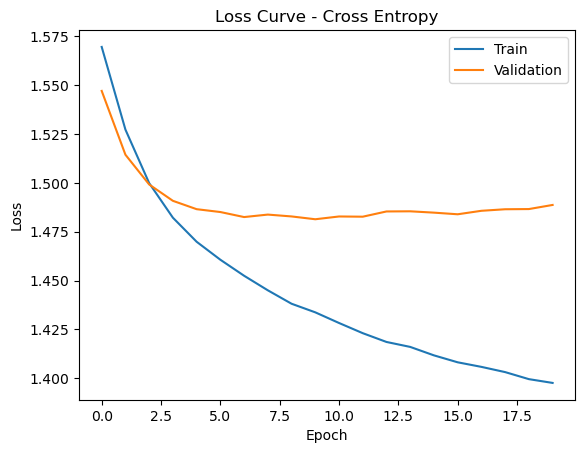

Train MAE: 0.6730125
Train MSE: 1.1758125
Test MAE: 0.8007
Test MSE: 1.3612


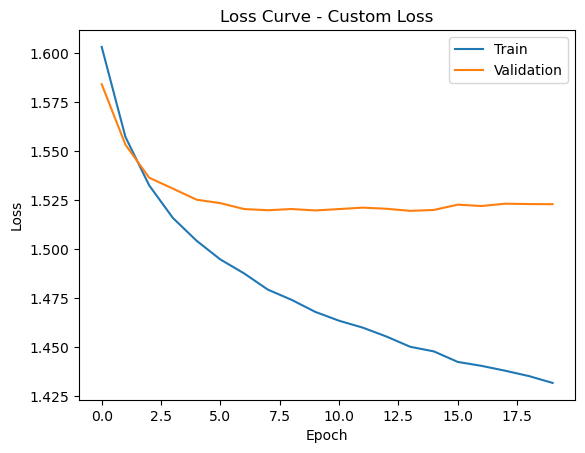

Train MAE: 0.6637375
Train MSE: 1.1445625
Test MAE: 0.7853
Test MSE: 1.3118


In [7]:
# Run custom and CE loss models
train_and_evaluate(use_custom_loss=False)
train_and_evaluate(use_custom_loss=True)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.metrics import roc_auc_score
import pandas as pd
import random

def load_implicit_data():
    df = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
    df['user_id'] -= 1
    df['item_id'] -= 1
    df = df[df['rating'] >= 4]

    def build_dict(d):
        result = {}
        for row in d.itertuples():
            result.setdefault(row.user_id, set()).add(row.item_id)
        return result

    pos_data = torch.tensor(df[['user_id', 'item_id']].values, dtype=torch.long)
    indices = np.random.permutation(len(pos_data))
    train_size = int(0.8 * len(pos_data))
    train_idx = indices[:train_size]
    test_idx = indices[train_size:]

    train_dict = build_dict(df.iloc[train_idx])
    test_dict = build_dict(df.iloc[test_idx])

    n_users = df['user_id'].max() + 1
    n_items = df['item_id'].max() + 1

    return train_dict, test_dict, n_users, n_items, pos_data[train_idx], pos_data[test_idx]

# 1. Complete the MLP class
class MLP(nn.Module):
    def __init__(self, input_dim, n_hidden=1, hidden_size=64, dropout=0.):
        super().__init__()
        layers = [nn.Dropout(dropout)]
        for _ in range(n_hidden):
            layers.append(nn.Linear(input_dim, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = hidden_size
        layers.append(nn.Linear(input_dim, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x).squeeze(-1)

class MarginLoss(nn.Module):
    def __init__(self, margin):
        super().__init__()
        self.margin = margin

    def forward(self, pos_score, neg_score):
        return torch.mean(F.relu(neg_score - pos_score + self.margin))

# 2. Complete the DeepTripletModel
class DeepTripletModel(nn.Module):
    def __init__(self, n_users, n_items, user_dim=32, item_dim=64, margin=0.5, 
                 n_hidden=1, hidden_size=64, dropout=0, l2_reg=0.):
        super().__init__()
        self.user_layer = nn.Embedding(n_users, user_dim)
        self.item_layer = nn.Embedding(n_items, item_dim)
        self.mlp = MLP(user_dim + item_dim, n_hidden, hidden_size, dropout)
        self.margin_loss = MarginLoss(margin)
        self.l2_reg = l2_reg

    def forward(self, user_ids, pos_item_ids, neg_item_ids):
        u = self.user_layer(user_ids)
        ip = self.item_layer(pos_item_ids)
        ineg = self.item_layer(neg_item_ids)
        pos_input = torch.cat([u, ip], dim=1)
        neg_input = torch.cat([u, ineg], dim=1)
        pos_score = self.mlp(pos_input)
        neg_score = self.mlp(neg_input)
        loss = self.margin_loss(pos_score, neg_score)
        l2 = self.user_layer.weight.norm(2) + self.item_layer.weight.norm(2)
        # loss += self.l2_reg * l2
        return loss

class DeepMatchModel(nn.Module):
    def __init__(self, user_layer, item_layer, mlp):
        super().__init__()
        self.user_layer = user_layer
        self.item_layer = item_layer
        self.mlp = mlp

    def forward(self, user_ids, item_ids):
        u = self.user_layer(user_ids)
        i = self.item_layer(item_ids)
        return self.mlp(torch.cat([u, i], dim=1))

class TripletDataset(Dataset):
    def __init__(self, pos_data, n_items, neg_samples=1):
        self.pos_data = pos_data
        self.n_items = n_items
        self.neg_samples = neg_samples
        self.user_to_pos_items = {}
        for u, i in pos_data:
            u, i = u.item(), i.item()
            self.user_to_pos_items.setdefault(u, []).append(i)

    def __len__(self):
        return len(self.pos_data) * self.neg_samples

    def __getitem__(self, idx):
        pos_idx = idx // self.neg_samples
        u, pi = self.pos_data[pos_idx]
        u, pi = u.item(), pi.item()
        pos_items = set(self.user_to_pos_items[u])
        while True:
            ni = random.randint(0, self.n_items - 1)
            if ni not in pos_items:
                break
        return torch.tensor(u), torch.tensor(pi), torch.tensor(ni)

# 3. Complete the evaluation function
def average_roc_auc(model, pos_data_train, pos_data_test):
    model.eval()
    aucs = []
    test_users = set(pos_data_test[:, 0].numpy())
    for u in test_users:
        pos_items = pos_data_test[pos_data_test[:, 0] == u][:, 1].numpy()
        if len(pos_items) == 0:
            continue
        train_items = pos_data_train[pos_data_train[:, 0] == u][:, 1].numpy()
        all_items = set(range(model.item_layer.num_embeddings))
        neg_items = list(all_items - set(train_items) - set(pos_items))
        if len(neg_items) > 100:
            neg_items = random.sample(neg_items, 100)
        eval_items = np.concatenate([pos_items, neg_items])
        true_labels = np.zeros(len(eval_items))
        true_labels[:len(pos_items)] = 1
        u_tensor = torch.tensor([u] * len(eval_items), dtype=torch.long)
        i_tensor = torch.tensor(eval_items, dtype=torch.long)
        with torch.no_grad():
            preds = model(u_tensor, i_tensor).numpy()
        if len(np.unique(true_labels)) > 1:
            aucs.append(roc_auc_score(true_labels, preds))
    return np.mean(aucs) if aucs else 0.0

# 4. Implement the training loop
def train_deep_recsys():
    train_dict, test_dict, n_users, n_items, train_data, test_data = load_implicit_data()

    model = DeepTripletModel(n_users, n_items, user_dim=32, item_dim=64, hidden_size=128, n_hidden=1, dropout=0.3, l2_reg=1e-5)
    match_model = DeepMatchModel(model.user_layer, model.item_layer, model.mlp)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    dataset = TripletDataset(train_data, n_items, neg_samples=5)
    loader = DataLoader(dataset, batch_size=128, shuffle=True)

    for epoch in range(20):
        model.train()
        total_loss = 0
        for batch in loader:
            u, pi, ni = batch
            optimizer.zero_grad()
            loss = model(u, pi, ni)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        auc = average_roc_auc(match_model, train_data, test_data)
        print(f"Epoch {epoch+1}/20 - Loss: {total_loss/len(loader):.4f}, AUC: {auc:.4f}")

train_deep_recsys()

Epoch 1/20 - Loss: 0.2791, AUC: 0.8640
Epoch 2/20 - Loss: 0.1919, AUC: 0.8705
Epoch 3/20 - Loss: 0.1784, AUC: 0.8722
Epoch 4/20 - Loss: 0.1724, AUC: 0.8727
Epoch 5/20 - Loss: 0.1685, AUC: 0.8736
Epoch 6/20 - Loss: 0.1654, AUC: 0.8726
Epoch 7/20 - Loss: 0.1640, AUC: 0.8734
Epoch 8/20 - Loss: 0.1617, AUC: 0.8744
Epoch 9/20 - Loss: 0.1606, AUC: 0.8729
Epoch 10/20 - Loss: 0.1602, AUC: 0.8734
Epoch 11/20 - Loss: 0.1590, AUC: 0.8737
Epoch 12/20 - Loss: 0.1573, AUC: 0.8759
Epoch 13/20 - Loss: 0.1556, AUC: 0.8760
Epoch 14/20 - Loss: 0.1525, AUC: 0.8797
Epoch 15/20 - Loss: 0.1484, AUC: 0.8824
Epoch 16/20 - Loss: 0.1456, AUC: 0.8851
Epoch 17/20 - Loss: 0.1417, AUC: 0.8913
Epoch 18/20 - Loss: 0.1382, AUC: 0.8961
Epoch 19/20 - Loss: 0.1338, AUC: 0.9003
Epoch 20/20 - Loss: 0.1306, AUC: 0.9035
